# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Елохов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

Уравнение гиперплоскости: $$g(x) = w_0 + w_1x_1 + w_2x_2 = \langle w, x \rangle + w_0 =  w^\top x + w_0$$



Сигмоида: $$\sigma(z) = \frac{1}{1 + exp{(-z)}},$$



Функция потерь: $$L(w) = - \sum_i \log(\sigma(y^{(i)} g(x^{(i)})) \rightarrow \min_w$$


Градиент: 
$$g(X) = w^\top X + w_0E,$$
$$E = \begin{pmatrix} 1&\dots&1 \end{pmatrix} $$ 



$$ \frac{\partial L}{\partial W} = ((\sigma(g(X)*y) - 1)*y)X_1,$$

$$ X_1 = \begin{bmatrix} 1 & x_{11} & x_{12} & \dots \\ \dots&\dots&\dots&\dots \\ 1 & x_{n1} & x_{n2} & \dots   \end{bmatrix} $$


In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=0.1, alpha=0.2, max_epoch=20, n_batch=5):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.n_batch = n_batch
        return
    
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def hyperplane(self, X, W):
        return X.dot(W[1::]) + W[0]

    def loss_function(self, X, y, W):
        margin = y * self.hyperplane(X, W) 
        return (-np.sum(np.log(self.sigmoid(margin))) + self.C * np.sum(W**2))
    
    def mini_batch_sgd(self, X, y, iserr, isloss, extra=False):
        np.random.seed(0)
        self.losses = []
        scale = 5.0
        y[y==0] = -1
        epoch = 1
        if(extra):
            W = self.weights
        else:
            W = np.random.rand(X.shape[1] + 1) * 2.0*scale - scale
        Joined = np.concatenate((X, y.reshape(X.shape[0],1)), axis=1)
        
        while(epoch <= self.max_epoch):
            Shuffle = Joined
            np.random.shuffle(Shuffle)
            X_shuffled = Shuffle[:, :-1]
            y_shuffled = Shuffle[:, -1]
            batchsize = Shuffle.shape[0]/self.n_batch
            for cur_batch in xrange(self.n_batch):
                X_batch = X_shuffled[cur_batch*batchsize:(cur_batch+1)*batchsize]
                y_batch = y_shuffled[cur_batch*batchsize:(cur_batch+1)*batchsize]
                grad = ((self.sigmoid(self.hyperplane(X_batch, W) * y_batch) - 1.0) * y_batch).dot(
                    np.concatenate((np.ones(X_batch.shape[0]).reshape(X_batch.shape[0], 1), X_batch), axis=1)) + 2.0*self.C*W
                #grad = grad/float(X.shape[0])
                W = W - self.alpha/epoch * grad
            #последний батч не вошел в цикл:
            X_batch = X_shuffled[self.n_batch*batchsize:]
            y_batch = y_shuffled[self.n_batch*batchsize:]
            grad = ((self.sigmoid(self.hyperplane(X_batch, W) * y_batch) - 1.0) * y_batch).dot(
                np.concatenate((np.ones(X_batch.shape[0]).reshape(X_batch.shape[0], 1), X_batch), axis=1)) + 2.0*self.C*W
            #grad = grad/float(X.shape[0])
            W = W - self.alpha/epoch * grad
            if(isloss):
                loss = self.loss_function(X, y, W)
                self.losses.append(loss)
            if(iserr):
                print('Epoch: %d' %epoch) 
                error = np.sum(y * np.sign(self.hyperplane(X, W)) < 0)
                loss = self.loss_function(X, y, W)
                print('Error = %f' %error)
                print('Loss = %f' %loss)
                print('============================================================')
            epoch += 1
        return W
    
    def fit(self, X, y=None, iserr=False, isloss=False):
        '''
        Обучение модели
        '''
        self.weights = self.mini_batch_sgd(X, y, iserr=iserr, isloss=isloss)
        return self
    
    def partial_fit(self, X, y=None, iserr=False, isloss=False):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.weights = self.mini_batch_sgd(X, y, iserr=iserr, isloss=isloss, extra=True)
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = np.sign(self.hyperplane(X, self.weights))
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        proba = self.sigmoid(self.hyperplane(X, self.weights))
        y_hat_proba = np.array([proba, 1-proba])
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

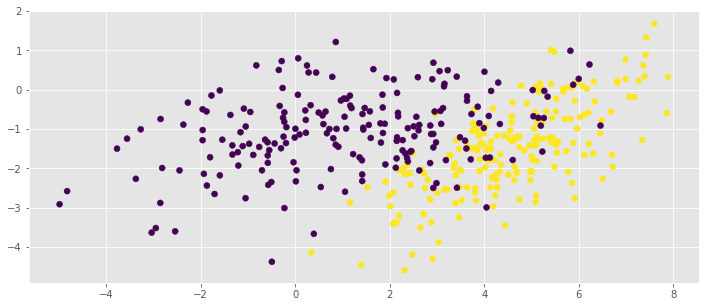

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
model = MySGDClassifier(max_epoch=50)
model.fit(X, y, iserr=True)

Epoch: 1
Error = 134.000000
Loss = 5759.241018
Epoch: 2
Error = 110.000000
Loss = 1986.888060
Epoch: 3
Error = 50.000000
Loss = 149.257774
Epoch: 4
Error = 120.000000
Loss = 2272.096390
Epoch: 5
Error = 110.000000
Loss = 1571.209972
Epoch: 6
Error = 90.000000
Loss = 708.998590
Epoch: 7
Error = 64.000000
Loss = 250.844684
Epoch: 8
Error = 44.000000
Loss = 126.482868
Epoch: 9
Error = 60.000000
Loss = 131.785558
Epoch: 10
Error = 46.000000
Loss = 119.844009
Epoch: 11
Error = 51.000000
Loss = 124.958407
Epoch: 12
Error = 41.000000
Loss = 130.222954
Epoch: 13
Error = 43.000000
Loss = 119.995872
Epoch: 14
Error = 44.000000
Loss = 140.275416
Epoch: 15
Error = 42.000000
Loss = 122.210454
Epoch: 16
Error = 46.000000
Loss = 117.281127
Epoch: 17
Error = 42.000000
Loss = 118.474812
Epoch: 18
Error = 42.000000
Loss = 117.641271
Epoch: 19
Error = 45.000000
Loss = 116.187226
Epoch: 20
Error = 45.000000
Loss = 116.026025
Epoch: 21
Error = 59.000000
Loss = 127.385790
Epoch: 22
Error = 51.000000
Loss = 

MySGDClassifier(C=0.1, alpha=0.2, max_epoch=50, n_batch=5)

In [6]:
## Your Code Here
W = model.weights
print('Weights:')
print W

Weights:
[-6.57021605  1.41910443 -1.60550848]


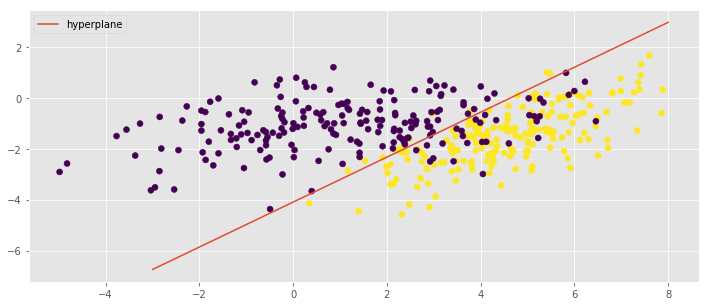

In [7]:
x_axis = np.linspace(-3, 8, 10)
y_axis = -W[0]/W[2] - W[1]/W[2]*x_axis
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_axis, y_axis)
plt.legend(['hyperplane'])
plt.show()

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

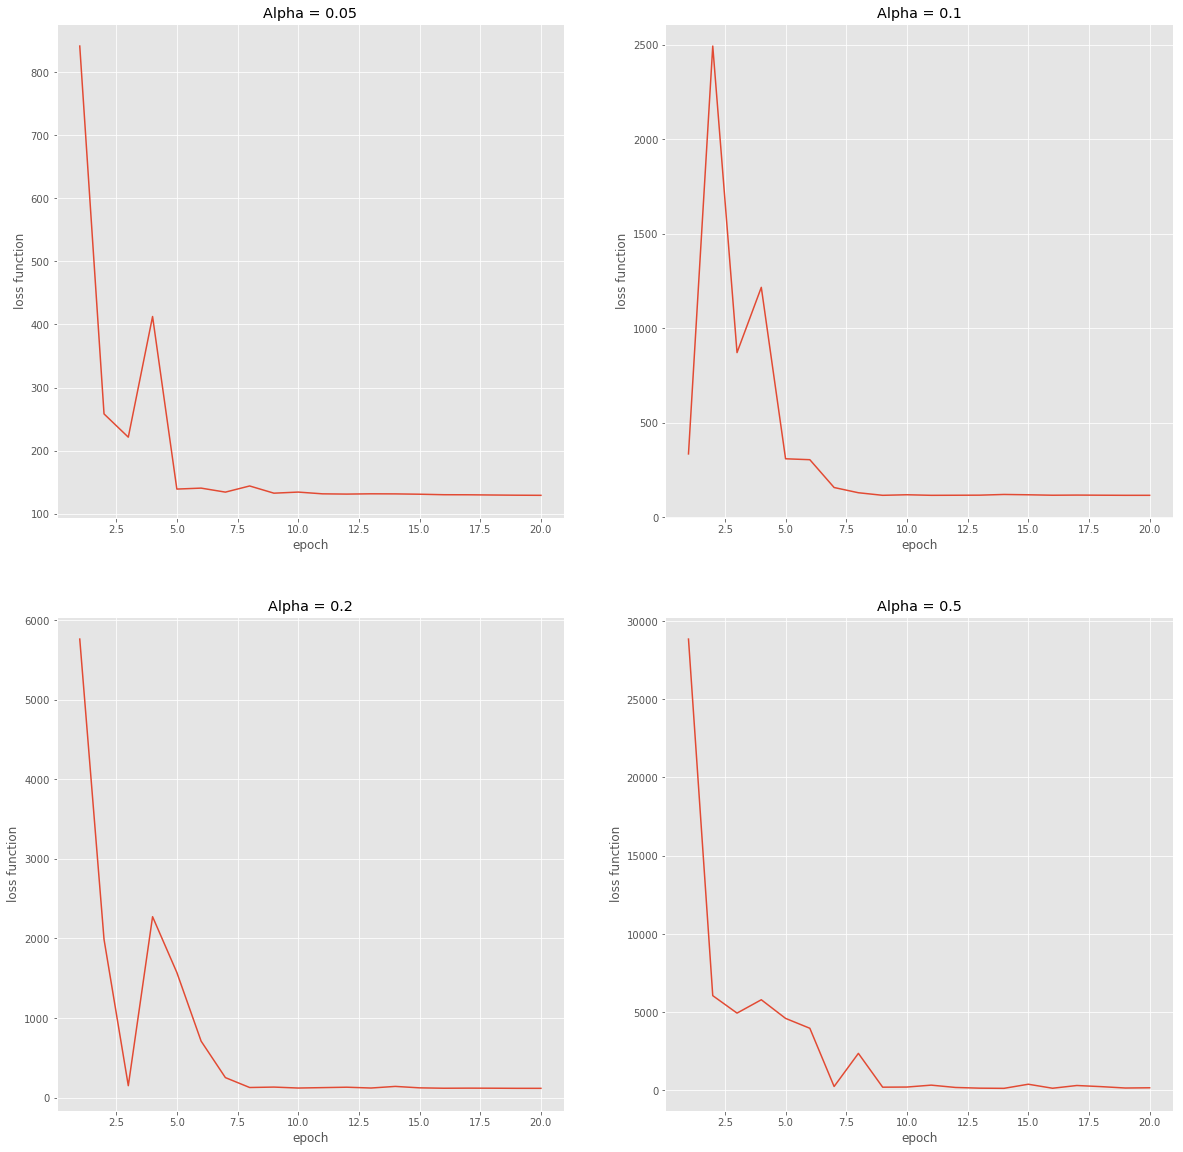

In [8]:
## Your Code Here
alphas = [0.05, 0.1, 0.2, 0.5]
plt.figure(figsize=(20,20))
for i in xrange(len(alphas)):
    model = MySGDClassifier(alpha=alphas[i])
    model.fit(X, y, isloss=True)
    plt.subplot(2, 2, i + 1)
    x_axis = np.linspace(1, model.max_epoch, model.max_epoch)
    y_axis = model.losses
    plt.plot(x_axis, y_axis)
    plt.title('Alpha = %s' %alphas[i])
    plt.xlabel('epoch')
    plt.ylabel('loss function')
plt.show()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [9]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [10]:
print df_data.shape
df_data.head()

(500000, 45)


,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [12]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [14]:
## Youd Code Here
unique_cards =  df_data.player_hero_card_id.value_counts().index.tolist()
print 'Unique cards:'
print unique_cards
print sorted(unique_cards) == sorted(df_data.opponent_hero_card_id.value_counts().index.tolist())
unique_cards.sort()

Unique cards:
[1235, 25, 494, 798, 754, 612, 981, 390, 326]
True


In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
enc = encoder.fit_transform(np.array(unique_cards).reshape(-1,1))
print enc
enc_pl = encoder.transform(df_data.loc[:, ['player_hero_card_id']].values)
enc_op = encoder.transform(df_data.loc[:, ['opponent_hero_card_id']].values)

name_pl = 'player_hero_card_id='
name_op = 'opponent_hero_card_id='

for i in xrange(len(unique_cards)):
    df_data.loc[:, name_pl + str(unique_cards[i])] = enc_pl[:, i]
for i in xrange(len(unique_cards)):
    df_data.loc[:, name_op + str(unique_cards[i])] = enc_op[:, i]


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [16]:
df_data.drop(u'player_hero_card_id', axis=1, inplace=True)
df_data.drop(u'opponent_hero_card_id', axis=1, inplace=True)
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1.0,1.0,1.0,1.0,0.0
turn,14.0,7.0,5.0,8.0,13.0
opponent_armor,0.0,0.0,3.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,5.0,22.0,29.0,26.0,30.0
opponent_special_skill_used,0.0,0.0,0.0,0.0,0.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,6.0,4.0,7.0,10.0
opponent_crystals_current,10.0,6.0,1.0,7.0,1.0
opponent_deck_count,11.0,19.0,22.0,17.0,12.0


In [17]:
df_data.to_csv('./trainingData_tabular_chunk1_changed.csv')

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [18]:
## Youd Code Here
#для линейной независимости
df_data.drop(u'opponent_hero_card_id=1235', axis=1, inplace=True)
df_data.drop(u'player_hero_card_id=1235', axis=1, inplace=True)
df_data.shape

(500000, 58)

In [19]:
X, y = df_data.loc[:, u'turn':].values, df_data.loc[:, u'decision'].values

In [20]:
print X.shape
print y.shape

(500000L, 57L)
(500000L,)


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [22]:
model = MySGDClassifier(alpha=0.002, C=1.0, n_batch=100)
model.fit(X_norm, y, iserr=True)

Epoch: 1
Error = 191708.000000
Loss = 3397465.535314
Epoch: 2
Error = 188767.000000
Loss = 1234190.655051
Epoch: 3
Error = 185500.000000
Loss = 831598.283346
Epoch: 4
Error = 185405.000000
Loss = 659070.471730
Epoch: 5
Error = 182631.000000
Loss = 532635.692614
Epoch: 6
Error = 179089.000000
Loss = 427934.303306
Epoch: 7
Error = 179349.000000
Loss = 389267.084183
Epoch: 8
Error = 170738.000000
Loss = 340841.891798
Epoch: 9
Error = 164258.000000
Loss = 300933.380803
Epoch: 10
Error = 149831.000000
Loss = 274219.404812
Epoch: 11
Error = 150008.000000
Loss = 274111.775177
Epoch: 12
Error = 149736.000000
Loss = 274162.275055
Epoch: 13
Error = 149813.000000
Loss = 273999.798729
Epoch: 14
Error = 150141.000000
Loss = 274009.495705
Epoch: 15
Error = 149772.000000
Loss = 273985.158251
Epoch: 16
Error = 149826.000000
Loss = 273963.924425
Epoch: 17
Error = 149916.000000
Loss = 273947.543430
Epoch: 18
Error = 149715.000000
Loss = 273886.658914
Epoch: 19
Error = 149834.000000
Loss = 273934.889410


MySGDClassifier(C=1.0, alpha=0.002, max_epoch=20, n_batch=100)

In [23]:
print model.weights
np.save('./model', model.weights)

[ 0.03647121  0.59533767 -0.02591649 -0.03238199 -0.68929522  0.05534087
 -0.01332127  0.08188154  0.04026188  0.00321857  0.06924492 -0.31295005
  0.56796982  0.02673721  0.04550691  0.66404724 -0.05820462  0.01120846
 -0.39130898  0.12198379  0.36354886 -0.06032539  0.1201098   0.35962699
 -0.48202721 -0.4926352  -0.01418379 -0.35344372 -0.05575655 -0.49449711
  0.49895634  0.1072739   0.267131    0.20900721 -0.3974234  -0.30197899
 -0.21415291  0.48302164  0.01362817  0.14110873  0.0267839   0.11521779
 -0.05556077  0.06845268  0.03794792  0.05116037  0.03945686  0.08071994
  0.1036209  -0.01229736 -0.0502622  -0.09696109 -0.05329901 -0.04987467
 -0.09555924 -0.01897774 -0.12239536 -0.03849656]


## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [24]:
## Youd Code Here
filepath = './testData_tabular.csv'
df_data = pd.read_csv(filepath, sep=',')
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')
unique_cards =  df_data.player_hero_card_id.value_counts().index.tolist()
unique_cards.sort()

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
enc = encoder.fit_transform(np.array(unique_cards).reshape(-1,1))
enc_pl = encoder.transform(df_data.loc[:, ['player_hero_card_id']].values)
enc_op = encoder.transform(df_data.loc[:, ['opponent_hero_card_id']].values)

name_pl = 'player_hero_card_id='
name_op = 'opponent_hero_card_id='

for i in xrange(len(unique_cards)):
    df_data.loc[:, name_pl + str(unique_cards[i])] = enc_pl[:, i]
for i in xrange(len(unique_cards)):
    df_data.loc[:, name_op + str(unique_cards[i])] = enc_op[:, i]
    
df_data.drop(u'player_hero_card_id', axis=1, inplace=True)
df_data.drop(u'opponent_hero_card_id', axis=1, inplace=True)
df_data.drop(u'opponent_hero_card_id=1235', axis=1, inplace=True)
df_data.drop(u'player_hero_card_id=1235', axis=1, inplace=True)
df_data.shape

(750000, 58)

In [25]:
X = df_data.loc[:, u'turn':].values
print X.shape
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

(750000L, 57L)


In [26]:
y = model.predict_proba(X_norm)
print y[0].shape
np.savetxt('./result.txt', y[0])

(750000L,)


In [27]:
print('nickname: elokhov; score=0.785')

nickname: elokhov; score=0.785
